Recreating high low time lag code from last year!

In [2]:
import numpy as np
import sys
sys.path.append('/home/c2032014/py_files/')
import numpy as np
import load_and_clean as lac
import rms_normalisation as rn
from stingray import Lightcurve, Powerspectrum, AveragedCrossspectrum
import dG_span_new as dgs
import G_span as gs
import frac_rms_span as frmss
import phase_span as phs
import fit_rms_phase as frp
import F_test as ft
import frac_rms_err_span as fres
import phase_err_span as pes
import chi_square as chis
import importlib
importlib.reload(frp)
importlib.reload(ft)
importlib.reload(gs)
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from more_itertools import locate
import math
import scipy.integrate as spi

In [3]:
file1= '/home/c2032014/CYGX1/event_1pt5/ixpe01002901_det12_evt1pt5_v01_src_1.fits'
file2= '/home/c2032014/CYGX1/event_1pt5/ixpe01002901_det3_evt1pt5_v01_src.fits'
Pmin=51
Pmax=200
gti='/home/c2032014/CYGX1/event_1pt5/GTI_ixpe01002901_evt1pt5_v01_src.txt'
bin_length=1/64
seg_length=16
fmin=0
fmax=5
f_bin_number=8
mod_min=np.radians(-90)
mod_max=np.radians(90)
mod_bin_number=20
J=mod_bin_number
spur_sub=True
coherence_corrector=False

In [4]:
#Loading and cleaning data
data_1,header_1,*_=lac.load_and_clean(file1,Pmin,Pmax)
data_2,header_2,*_=lac.load_and_clean(file2,Pmin,Pmax)

In [5]:
GTI=list(np.loadtxt(str(gti)))

In [6]:
theta=np.radians(-20)

In [7]:
mod_bin_index_1=list(locate(data_1['phi'], lambda q: q>theta+(np.pi/4) or q<theta-(np.pi/4))) 
selected_data_1=data_1[mod_bin_index_1]

mod_bin_index_2=[i<theta+(np.pi)/4 and i>theta-np.pi/4 for i in data_2['phi']]
selected_data_2=data_2[mod_bin_index_2]

In [8]:
lc_1=Lightcurve.make_lightcurve(selected_data_1['TIME'],dt=1/256,gti=GTI)
lc_1.apply_gtis()

lc_2=Lightcurve.make_lightcurve(selected_data_2['TIME'],dt=1/256,gti=GTI)
lc_2.apply_gtis()


In [9]:
cs=AveragedCrossspectrum.from_lightcurve(lc_1,lc_2,16,norm='frac')
cs=cs.rebin_log(f=0.6)

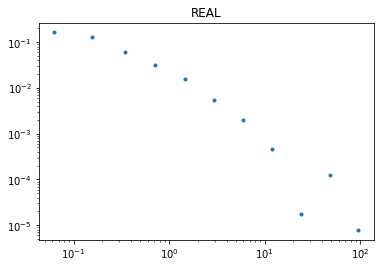

In [21]:
plt.figure()
plt.xscale('log')
plt.yscale('log')
plt.title('REAL')
plt.plot(cs.freq,cs.power.real,'.')
plt.show()

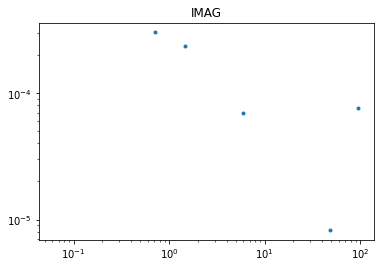

In [22]:
plt.figure()
plt.xscale('log')
plt.yscale('log')
plt.title('IMAG')
plt.plot(cs.freq,cs.power.imag,'.')
plt.show()

In [23]:
power=cs.power


t_lag_array=[]
for complex_val in power:
    real=complex_val.real
    imag=complex_val.imag
    arg=math.atan(imag/real)
    t_lag=arg/2*np.pi
    t_lag_array.append(t_lag)

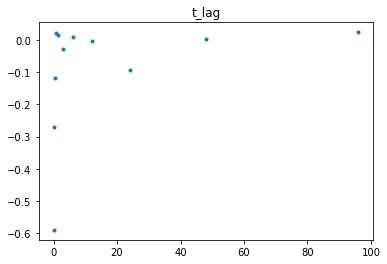

In [24]:
plt.figure()
plt.plot(cs.freq,(t_lag_array/cs.freq),'.')
#plt.xscale('log')
#plt.yscale('log')
plt.title('t_lag')
plt.show()



Now the same subtracting spurious polarisartion

In [10]:
q_1_tot=np.sum(data_1['Q'])
q_2_tot=np.sum(data_2['Q'])
q_tot=q_1_tot+q_2_tot
q_len_tot=len(data_1['Q'])+len(data_2['Q'])
Q=q_tot

u_1_tot=np.sum(data_1['U'])
u_2_tot=np.sum(data_2['U'])
u_tot=u_1_tot+u_2_tot
u_len_tot=len(data_1['U'])+len(data_2['U'])
U=u_tot

In [11]:

q_spur_1=selected_data_1['QSP']
u_spur_1=selected_data_1['USP']
q_1_spur_sum=np.sum(q_spur_1)
u_1_spur_sum=np.sum(u_spur_1)
q_spur_1_tot=q_1_spur_sum/len(q_spur_1)
u_spur_1_tot=u_1_spur_sum/len(u_spur_1)


q_spur_2=selected_data_2['QSP']
u_spur_2=selected_data_2['USP']
q_2_spur_sum=np.sum(q_spur_2)
u_2_spur_sum=np.sum(u_spur_2)
q_spur_2_tot=q_2_spur_sum/len(q_spur_2)
u_spur_2_tot=u_2_spur_sum/len(u_spur_2)


In [12]:
theta_new=0.5*math.atan2(U,Q)
print(math.degrees(theta_new))

-20.467035334796588


In [13]:
def f_1(x):
        return (((q_spur_1_tot*np.cos((2*x)))+(u_spur_1_tot*np.sin(((2*x))))))  


def f_2(x):
        return (((q_spur_2_tot*np.cos((2*x)))+(u_spur_2_tot*np.sin(((2*x))))))

In [14]:
# Define the integration bounds
lower_bound_1 = theta_new- np.pi/4
upper_bound_1 = theta_new + np.pi/4

In [15]:
# Perform the numerical integration
int_1 = spi.quad(f_1, lower_bound_1, upper_bound_1)

In [16]:
lower_bound_2 = theta_new + np.pi/4
upper_bound_2 = theta_new + (3*np.pi)/4

In [17]:
int_2 = spi.quad(f_2, lower_bound_2, upper_bound_2)

In [18]:
lc_1_countrate=lc_1.countrate
lc_2_countrate=lc_2.countrate

lc_1_spur_sub=(lc_1_countrate/2)*int_1[0]*bin_length
lc_2_spur_sub=(lc_2_countrate/2)*int_2[0]*bin_length



In [22]:
lc_1_spur_sub_counts=np.array([lc_1_spur_sub]*len(lc_1.time))
lc_2_spur_sub_counts=np.array([lc_2_spur_sub]*len(lc_2.time))

print(lc_1)
print(len(lc_1.time))
print(len(lc_1_spur_sub_counts))

lc_1_spur=Lightcurve(lc_1.time,lc_1_spur_sub_counts)
lc_2_spur=Lightcurve(lc_2.time,lc_2_spur_sub_counts)

lc_12_counts_subtracted=lc_12.counts-lc_12_spur_sub
lc_3_counts_subtracted=lc_3.counts-lc_3_spur_sub

lc_1=Lightcurve(lc_1.time,lc_12_counts_subtracted)
lc_2=Lightcurve(lc_2.time,lc_3_counts_subtracted)

cs=AveragedCrossspectrum.from_lightcurve(lc_1,lc_2,seg_length,norm='frac')
cs=cs.rebin_log(f=1.0)

MemoryError: Unable to allocate 28.5 PiB for an array with shape (63298166, 63298166) and data type float64

In [ ]:






t_lag_array=[]
        arg_array=[]
        for complex_val in power:
            arg= np.angle(complex_val)
            arg_array.append(arg)
           # real=complex_val.real
           # print(real)
           # imag=complex_val.imag
           # print(imag)
           # arg=math.atan2(imag,real)
           # t_lag=arg/2*np.pi
           # t_lag_array.append(t_lag)
        t_arg=arg_array/(2*np.pi*cs.freq)
       # time_lag=t_lag_array/cs.freq        
        freq_lags, freq_lags_err = cs.time_lag()
        np.savetxt('Results/tlag_spur'+str(source_name)+'_lag.txt',t_arg)
        np.savetxt('Results/tlag_freqs_spur'+str(source_name)+'.txt',cs.freq)
        np.savetxt('Results/tlag_err_spur'+str(source_name)+'.txt',freq_lags_err) 




